In [6]:
%load_ext autoreload
%autoreload 2
import os

from  partie1 import GRUEncoderGD, GRUDecoderGD
from  partie1 import GRUEncoderDG, GRUDecoderDG
from partie1 import TensorProductEncoder
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils

In [3]:
input_size = 10
output_size = 10
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001
num_layers = 1

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision= Accuracy(task="multiclass", num_classes=input_size).to(device) 

def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))


    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')

    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# EVAL 

## Gauche droite

/tmp/ipykernel_5727/2950450910.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load( "./models/GD/gru_enc_emb8_hid64.pth").to(device)
/tmp/ipykernel_5727

Loss moyenne : 0.09567426655068993
 Ecart type : 0.016850583414157336


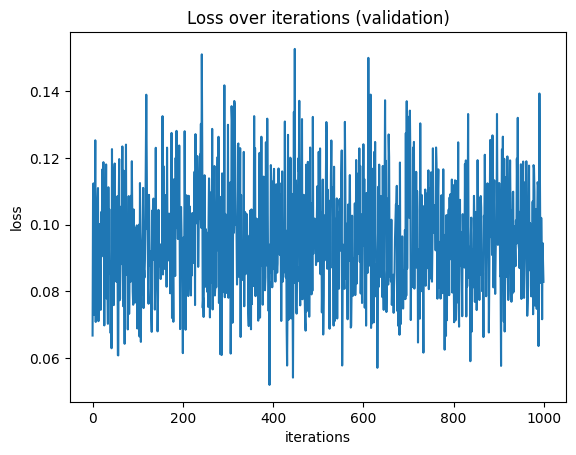

In [15]:
encoder = torch.load( "./models/GD/gru_enc_emb8_hid64.pth").to(device)
decoder = torch.load( "./models/GD/gru_dec_emb8_hid64.pth").to(device)

tpdn = torch.load("./models/TPDN/GD/tpdn_gru_emb8.pth").to(device)
    
criterion = nn.MSELoss()
loss_val = []
tpdn_outputs = []
rnn_outputs = []
for _ in range(1000) : 
    data , roles = generate_data(1, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    rnn_out, rnn_hidden = encoder(data)
    tpdn_output= tpdn(data, roles)
    # tpdn_output = torch.tensor(tpdn_output)
    tpdn_hidden = tpdn_output[:,-1,:]
    loss_val.append(criterion(tpdn_output[:,-1,:].cpu(), rnn_out[:,-1,:].cpu()).item())
    tpdn_outputs.append(tpdn_output)
    rnn_outputs.append(rnn_out)

loss_val = np.array(loss_val)
plt.plot(loss_val)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.title("Loss over iterations (validation)")

print("="*100)
print(f"Loss moyenne : {loss_val.mean()}")
print(f" Ecart type : {loss_val.std()}")
# print( rnn_out.shape)
# print(rnn_hidden.shape)
# print(tpdn_hidden.shape)
# print(tpdn_output.shape)



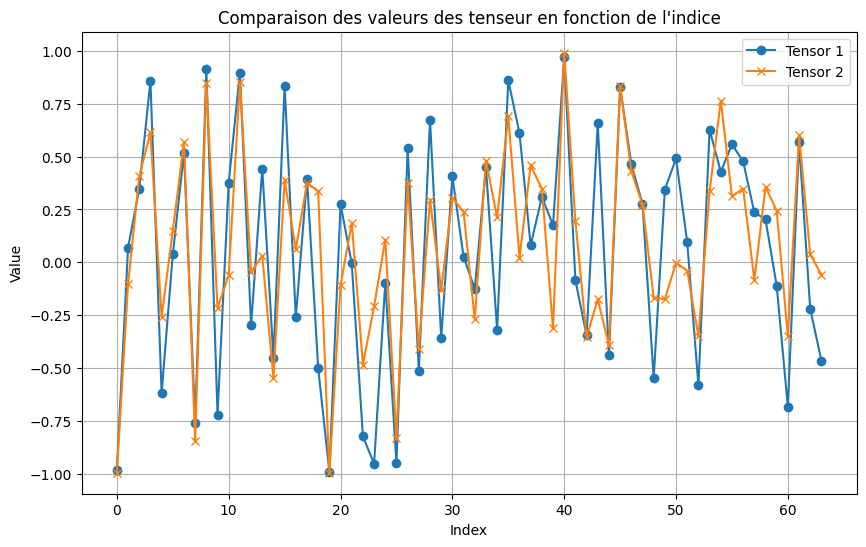

In [12]:

plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

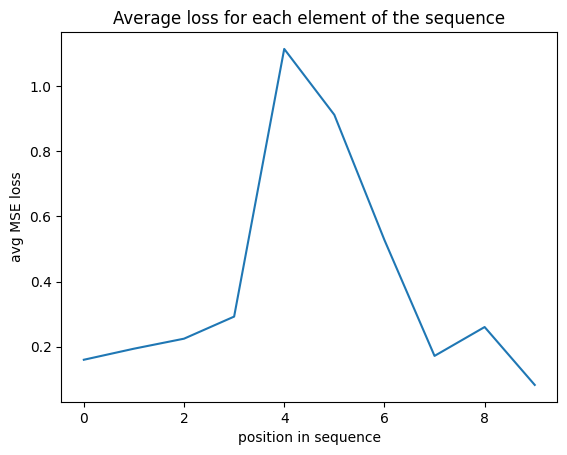

In [21]:
liste_error = []
error = {i : [] for i in range(tpdn_output.shape[1])}
# print( error)
criterion = nn.MSELoss()
for i in range(tpdn_output.shape[1]):
    error[i].append(criterion(tpdn_output[:,i,:].cpu(), rnn_out[:,i,:].cpu()).item())

error_avg  = {k: sum(v) / len(v) for k, v in error.items()}

avg = np.array([v for k, v in error_avg.items()])
plt.plot(avg)
plt.title("Average loss for each element of the sequence")
plt.xlabel("position in sequence")
plt.ylabel("avg MSE loss")
plt.show()

## Droite Gauche